In [2]:
import pickle5 as pickle
import pandas as pd
import yfinance as yf
import pandas_ta as ta
import numpy as np

In [3]:
#lstm generator architecture
from torch import nn
from torch.nn.utils import spectral_norm


class AddDimension(nn.Module):
    def forward(self, x):
        return x.unsqueeze(1)


class SqueezeDimension(nn.Module):
    def forward(self, x):
        return x.squeeze(1)

#Banushev
# def create_critic_architecture():
#     return nn.Sequential(nn.Conv1d(1, 32, kernel_size=1, stride=2),
#     nn.LeakyReLU(0.01),
#     nn.Conv1d(32, 64, kernel_size=1, stride=2),
#     nn.LeakyReLU(0.01),
#     nn.BatchNorm1d(64),
#     nn.Conv1d(64, 128, kernel_size=1, stride=2),
#     nn.LeakyReLU(0.01),
#     nn.BatchNorm1d(128),
#     nn.Linear (128, 220, bias=False), nn.BatchNorm1d(220), nn.LeakyReLU(0.01),
#     nn.Linear (220, 220, bias=False), nn.ReLU(),
#     nn.Linear(220, 1))
                         

def create_critic_architecture():
    return nn.Sequential(AddDimension(),
                         spectral_norm(nn.Conv1d(1, 32, 3, padding=1), n_power_iterations=10),
                         nn.LeakyReLU(0.2, inplace=True),
                         
                         
                         spectral_norm(nn.Conv1d(32, 32, 3, padding=1), n_power_iterations=10),
                         nn.LeakyReLU(0.2, inplace=True),
                         

                         spectral_norm(nn.Conv1d(32, 32, 3, padding=1), n_power_iterations=10),
                         nn.LeakyReLU(0.2, inplace=True),
                         nn.Flatten(),

                         nn.Linear(32, 50),
                         nn.LeakyReLU(0.2, inplace=True),

                         nn.Linear(50, 15),
                         nn.LeakyReLU(0.2, inplace=True),

                         nn.Linear(15, 1)
                         )


class Generator(nn.Module):
    def __init__(self, num_embed=13, num_hidden=500, num_layers=1, sequence_length=1, output_size = 1, bidirectional=False):
        
        nn.Module.__init__(self)
        
        self.num_hidden = num_hidden
        
        self.rnn = nn.LSTM(num_embed, num_hidden, num_layers, bidirectional=bidirectional)
        self.decoder = nn.Linear(num_hidden, output_size)
    
    def forward(self, inputs):
        output, hidden = self.rnn(inputs)
        decoded = self.decoder(output)
        return decoded
    


class Critic(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.main = create_critic_architecture()

    def forward(self, inputs):
        return self.main(inputs)

In [ ]:
data_final

In [31]:
data_final = pd.read_pickle('df_final.pkl')

In [34]:
data_final.columns

Index(['minimum_pitch', 'maximum_pitch', 'median_f0', 'number_of_pulses',
       'jitter_local', 'jitter_local_absolute', 'jitter_rap', 'jitter_ppq5',
       'jitter_ddp', 'max_db', 'min_db', 'mean_db', 'HNR', 'VADER_neg',
       'VADER_neu', 'VADER_pos', 'VADER_compound', 'finBERT_pos',
       'finBERT_neg', 'finBERT_neu', '1_day_ret', '3_day_ret', '7_day_ret',
       '14_day_ret', '21_day_ret', '28_day_ret'],
      dtype='object')

In [5]:
data_final = data_final.drop(['3_day_ret', '7_day_ret', '14_day_ret', '21_day_ret', '28_day_ret'], axis=1)

In [6]:
data_final = data_final.drop(['VADER_neg','VADER_neu', 'VADER_pos', 'VADER_compound', 
                                    'finBERT_pos', 'finBERT_neg', 'finBERT_neu'], axis=1)

In [7]:
#turn data into their format
data_final_list = []
example_size = 1
for i in range (data_final.shape[0]-example_size):
    example = data_final.iloc[i:example_size+i].to_dict('series')
    for key in example.keys():
        example[key] = example[key].astype('float').to_list()
    data_final_list.append(example)

In [8]:
len(data_final_list)

293

In [9]:
train_data_proportion = int(.8*len(data_final_list))
train_data = data_final_list[:train_data_proportion]
test_data = data_final_list[train_data_proportion:]

In [10]:
import argparse
import os


import torch
from tqdm import tqdm
from torch.autograd import Variable
from torch.autograd import grad as torch_grad
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from math import pi

In [29]:
from sklearn.metrics import mean_absolute_error
class Trainer:
    NOISE_LENGTH = 50

    def __init__(self, generator, critic, gen_optimizer, critic_optimizer,
                 gp_weight=10, critic_iterations=5, print_every=50, use_cuda=False, checkpoint_frequency=200):
        self.g = generator
        self.g_opt = gen_optimizer
        self.c = critic
        self.c_opt = critic_optimizer
        self.losses = {'g': [], 'c': [], 'GP': [], 'gradient_norm': []}
        self.num_steps = 0
        self.use_cuda = use_cuda
        self.gp_weight = gp_weight
        self.critic_iterations = critic_iterations
        self.print_every = print_every
        self.checkpoint_frequency = checkpoint_frequency

        if self.use_cuda:
            self.g.cuda()
            self.c.cuda()

    def _critic_train_iteration(self, data):
    
        #My code
        #create generator data
        generator_data = []
        for key in data.keys():
            if (key != '1_day_ret'):
                generator_data.append([t.numpy() for t in data[key]])
        generator_data = torch.from_numpy(np.array(generator_data).astype('float64'))
        generator_data = generator_data.permute(1, 2, 0)
        
       
        #create critic data
        critic_data = torch.from_numpy(np.array([t.numpy() for t in data['1_day_ret']]).astype('float64'))
        critic_data = Variable(critic_data)
        critic_data = critic_data.permute (1, 0)
        
        
        
        
        generated_data = self.g(generator_data.float()) 
        # Get gradient penalty
#         print (generated_data.shape)

#         print (generated_data.shape)
#         print (critic_data.shape)
        generated_data = torch.squeeze(generated_data, 2).permute(1,0)

        # Pass data through the Critic
#         print (critic_data.shape)
#         print (generated_data.shape)
        
        c_real = self.c(critic_data.float())
        c_generated = self.c(generated_data.float())

#       
#         print ('here')
#         print (generated_data.shape)
#         print (critic_data.shape)

       

        gradient_penalty = self._gradient_penalty(critic_data, generated_data)
        self.losses['GP'].append(gradient_penalty.data.item())

        # Create total loss and optimize
        self.c_opt.zero_grad()
        d_loss = -1*(c_generated.mean()**2) - (c_real.mean() -1)**2
        d_loss.backward()
        self.c_opt.step()

        self.losses['c'].append(d_loss.data.item())

    def _generator_train_iteration(self, data):
        self.g_opt.zero_grad()
        
        #create generator data
        generator_data = []
        for key in data.keys():
            if (key != '1_day_ret'):
                generator_data.append([t.numpy() for t in data[key]])
        generator_data = torch.from_numpy(np.array(generator_data).astype('float64'))
        generator_data = generator_data.permute(1, 2, 0)
        generator_result= self.g(generator_data.float())
        
        
        generator_result = torch.squeeze(generator_result, 2).permute(1,0)
        
        # Calculate loss and optimize
        d_generated = self.c(generator_result.float())
        g_loss = - (d_generated.mean()-1)**2
        g_loss.backward()
        self.g_opt.step()
        self.losses['g'].append(g_loss.data.item())

    def _gradient_penalty(self, real_data, generated_data):
        
#         print (real_data.shape)
#         print (generated_data.shape)
        batch_size = real_data.size()[0]

        # Calculate interpolation
        alpha = torch.rand(batch_size, 1)
        alpha = alpha.expand_as(real_data)
        if self.use_cuda:
            alpha = alpha.cuda()
        interpolated = alpha * real_data + (1 - alpha) * generated_data
        interpolated = Variable(interpolated, requires_grad=True)
#         print (interpolated.shape)
        if self.use_cuda:
            interpolated = interpolated.cuda()

        # Pass interpolated data through Critic
        prob_interpolated = self.c(interpolated.float())

        # Calculate gradients of probabilities with respect to examples
        gradients = torch_grad(outputs=prob_interpolated, inputs=interpolated,
                               grad_outputs=torch.ones(prob_interpolated.size()).cuda() if self.use_cuda
                               else torch.ones(prob_interpolated.size()), create_graph=True,
                               retain_graph=True)[0]
        # Gradients have shape (batch_size, num_channels, series length),
        # here we flatten to take the norm per example for every batch
        gradients = gradients.view(batch_size, -1)
        self.losses['gradient_norm'].append(gradients.norm(2, dim=1).mean().data.item())

        # Derivatives of the gradient close to 0 can cause problems because of the
        # square root, so manually calculate norm and add epsilon
        gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

        # Return gradient penalty
        return self.gp_weight * ((gradients_norm - 1) ** 2).mean()

    def _train_epoch(self, data_loader, epoch, writer):
        for i, data in enumerate(data_loader):
            
            #my code 
            data_size = 100
            #print (len(data['AAPL']))
            
            
            self.num_steps += 1
            self._critic_train_iteration(data)
            # Only update generator every critic_iterations iterations
            if self.num_steps % self.critic_iterations == 0:
                self._generator_train_iteration(data)

            if i % self.print_every == 0:
                global_step = i + epoch * len(data_loader.dataset)
                writer.add_scalar('Losses/Critic', self.losses['c'][-1], global_step)
                writer.add_scalar('Losses/Gradient Penalty', self.losses['GP'][-1], global_step)
                writer.add_scalar('Gradient Norm', self.losses['gradient_norm'][-1], global_step)

                if self.num_steps > self.critic_iterations:
                    writer.add_scalar('Losses/Generator', self.losses['g'][-1], global_step)

    def train(self, data_loader, data_list, epochs, plot_training_samples=True, checkpoint=None, writer=None):
        
        eval_data = []
        for data in test_data:
            generator_data = []
            for key in data.keys():
                generator_data.append(data[key])
            generator_data = torch.from_numpy(np.array(generator_data).astype('float64'))
            generator_data = torch.unsqueeze (generator_data, 0)
            data_cur = generator_data.permute(2, 0, 1)
            eval_data.append(data_cur)
        
        if checkpoint:
            path = os.path.join('checkpoints', checkpoint)
            state_dicts = torch.load(path, map_location=torch.device('cpu'))
            self.g.load_state_dict(state_dicts['g_state_dict'])
            self.c.load_state_dict(state_dicts['d_state_dict'])
            self.g_opt.load_state_dict(state_dicts['g_opt_state_dict'])
            self.c_opt.load_state_dict(state_dicts['d_opt_state_dict'])
       
#         # Define noise_shape
#         noise_shape = (1, self.NOISE_LENGTH)
        
#         if plot_training_samples:
#             # Fix latents to see how series generation improves during training
#             fixed_latents = Variable(self.sample_latent(noise_shape))
#             if self.use_cuda:
#                 fixed_latents = fixed_latents.cuda()

        #my code
        self.g = self.g.float()
        self.c = self.c.float()
        
        returns_generated = []
        returns_true = []
        MAE_list = []
        
        for epoch in tqdm(range(epochs)):

#             # Sample a different region of the latent distribution to check for mode collapse
#             dynamic_latents = Variable(self.sample_latent(noise_shape))
#             if self.use_cuda:
#                 dynamic_latents = dynamic_latents.cuda()

            self._train_epoch(data_loader, epoch + 1, writer)

#             # Save checkpoint
#             if epoch % self.checkpoint_frequency == 0:
#                 torch.save({
#                     'epoch': epoch,
#                     'd_state_dict': self.c.state_dict(),
#                     'g_state_dict': self.g.state_dict(),
#                     'd_opt_state_dict': self.c_opt.state_dict(),
#                     'g_opt_state_dict': self.g_opt.state_dict(),
#                 }, 'checkpoints/epoch_{}.pkl'.format(epoch))

            if plot_training_samples and (epoch % self.print_every == 0):
                self.g.eval()
            
                # Generate eval result (last sample period)
                returns_generated = []
                returns_true = []
                for data in eval_data:
                    train = data[:, :, :13]
                    true_val = data[:, :, 13]
#                     print (train)
#                     print (true_val)
                    generator_result= self.g(train.float())
                    generator_result = torch.squeeze(generator_result, 2).permute(1,0)
                    returns_generated.append(generator_result.detach().numpy()[0]*100)
                    returns_true.append(true_val.numpy()[0]*100)
                MAE = mean_absolute_error(returns_true, returns_generated)
                MAE_list.append(MAE)
                    
                print ("MAE")
                print (MAE)
                print ()
                
                plt.figure()
                plt.plot(returns_generated, label = 'generated')
                plt.plot (returns_true, label = 'true')
                plt.show()
                #plt.savefig('training_samples/fixed_latents/series_epoch_{}.png'.format(epoch))
                plt.close()

#                 plt.figure()
#                 plt.plot(fake_data_dynamic_latents.numpy()[0].T)
#                 #plt.savefig('training_samples/dynamic_latents/series_epoch_{}.png'.format(epoch))
#                 plt.show()
#                 plt.close()
                self.g.train()
        return returns_generated, returns_true
#     def sample_generator(self, latent_shape):
#         latent_samples = Variable(self.sample_latent(latent_shape))
#         if self.use_cuda:
#             latent_samples = latent_samples.cuda()

#         return self.g(latent_samples)

    @staticmethod
    def sample_latent(shape):
        return torch.randn(shape)

    def sample(self, num_samples):
        generated_data = self.sample_generator(num_samples)
        return generated_data.data.cpu().numpy()


def run_GAN():


    batch_size = 16
    epochs = 5000
    log_name = 'tensorboard_log_name'
    checkpoint = None
    

    # Instantiate Generator and Critic + initialize weights
    g = Generator()

    g_opt = torch.optim.RMSprop(g.parameters(), lr=0.0000005)
    d = Critic()

    d_opt = torch.optim.RMSprop(d.parameters(), lr=0.000005)
    
    #Create Dataloader
    dataset = train_data
    dataloader = DataLoader(dataset, batch_size=batch_size)


    # Instantiate Trainer
    trainer = Trainer(g, d, g_opt, d_opt, use_cuda=torch.cuda.is_available())
    # Train model
    print('Training is about to start...')
    # Instantiate Tensorboard writer
    tb_logdir = os.path.join('..', 'tensorboard', log_name)
    writer = SummaryWriter(tb_logdir)

    returns = trainer.train(dataloader, data_final_list, epochs=epochs, plot_training_samples=True, checkpoint=checkpoint, writer=writer)
    return returns









  0%|          | 0/5000 [00:00<?, ?it/s]

Training is about to start...
MAE
5.391970418085245



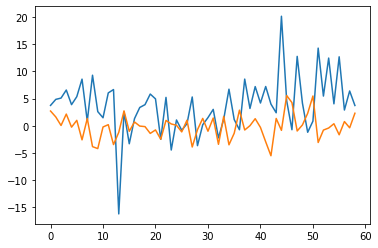









  0%|          | 1/5000 [00:00<35:30,  2.35it/s]







  0%|          | 2/5000 [00:00<31:55,  2.61it/s]







  0%|          | 3/5000 [00:00<29:05,  2.86it/s]







  0%|          | 4/5000 [00:01<27:09,  3.07it/s]







  0%|          | 5/5000 [00:01<25:42,  3.24it/s]







  0%|          | 6/5000 [00:01<24:36,  3.38it/s]







  0%|          | 7/5000 [00:02<25:32,  3.26it/s]







  0%|          | 8/5000 [00:02<24:39,  3.38it/s]







  0%|          | 9/5000 [00:02<24:08,  3.44it/s]







  0%|          | 10/5000 [00:02<24:11,  3.44it/s]







  0%|          | 11/5000 [00:03<23:39,  3.51it/s]







  0%|          | 12/5000 [00:03<23:22,  3.56it/s]







  0%|          | 13/5000 [00:03<23:14,  3.58it/s]







  0%|          | 14/5000 [00:04<23:11,  3.58it/s]







  0%|          | 15/5000 [00:04<23:22,  3.55it/s]







  0%|          | 16/5000 [00:04<23:17,  3.57it/s]







  0%|          | 17/5000 [00:04<23:07,  3.59it/s]







  0%|          | 18/5000 [00:05<

MAE
4.767560283971674



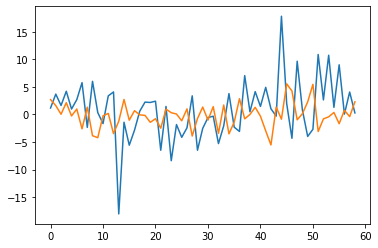









  1%|          | 51/5000 [00:14<27:25,  3.01it/s]







  1%|          | 52/5000 [00:15<26:46,  3.08it/s]







  1%|          | 53/5000 [00:15<25:45,  3.20it/s]







  1%|          | 54/5000 [00:15<25:05,  3.29it/s]







  1%|          | 55/5000 [00:16<24:31,  3.36it/s]







  1%|          | 56/5000 [00:16<24:23,  3.38it/s]







  1%|          | 57/5000 [00:16<24:03,  3.42it/s]







  1%|          | 58/5000 [00:16<24:05,  3.42it/s]







  1%|          | 59/5000 [00:17<23:25,  3.51it/s]







  1%|          | 60/5000 [00:17<23:03,  3.57it/s]







  1%|          | 61/5000 [00:17<23:05,  3.57it/s]







  1%|          | 62/5000 [00:18<23:40,  3.48it/s]







  1%|▏         | 63/5000 [00:18<23:54,  3.44it/s]







  1%|▏         | 64/5000 [00:18<23:58,  3.43it/s]







  1%|▏         | 65/5000 [00:18<24:05,  3.42it/s]







  1%|▏         | 66/5000 [00:19<24:02,  3.42it/s]







  1%|▏         | 67/5000 [00:19<24:05,  3.41it/s]







  1%|▏         | 68/500

MAE
5.261889505546739



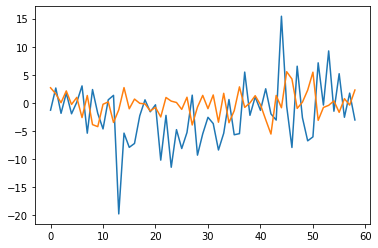









  2%|▏         | 101/5000 [00:29<28:15,  2.89it/s]







  2%|▏         | 102/5000 [00:30<27:12,  3.00it/s]







  2%|▏         | 103/5000 [00:30<26:11,  3.12it/s]







  2%|▏         | 104/5000 [00:30<25:05,  3.25it/s]







  2%|▏         | 105/5000 [00:30<24:57,  3.27it/s]







  2%|▏         | 106/5000 [00:31<24:51,  3.28it/s]







  2%|▏         | 107/5000 [00:31<24:42,  3.30it/s]







  2%|▏         | 108/5000 [00:31<24:31,  3.32it/s]







  2%|▏         | 109/5000 [00:32<24:28,  3.33it/s]







  2%|▏         | 110/5000 [00:32<24:18,  3.35it/s]







  2%|▏         | 111/5000 [00:32<24:24,  3.34it/s]







  2%|▏         | 112/5000 [00:33<24:30,  3.32it/s]







  2%|▏         | 113/5000 [00:33<24:24,  3.34it/s]







  2%|▏         | 114/5000 [00:33<24:36,  3.31it/s]







  2%|▏         | 115/5000 [00:33<24:28,  3.33it/s]







  2%|▏         | 116/5000 [00:34<24:21,  3.34it/s]







  2%|▏         | 117/5000 [00:34<24:19,  3.34it/s]







  2%|▏

MAE
6.359399724185758



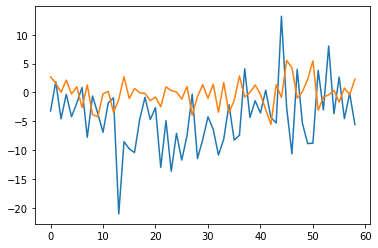









  3%|▎         | 151/5000 [00:44<29:53,  2.70it/s]







  3%|▎         | 152/5000 [00:45<28:50,  2.80it/s]







  3%|▎         | 153/5000 [00:45<27:16,  2.96it/s]







  3%|▎         | 154/5000 [00:45<26:37,  3.03it/s]







  3%|▎         | 155/5000 [00:46<25:49,  3.13it/s]







  3%|▎         | 156/5000 [00:46<25:19,  3.19it/s]







  3%|▎         | 157/5000 [00:46<24:39,  3.27it/s]







  3%|▎         | 158/5000 [00:47<24:09,  3.34it/s]







  3%|▎         | 159/5000 [00:47<23:55,  3.37it/s]







  3%|▎         | 160/5000 [00:47<23:50,  3.38it/s]







  3%|▎         | 161/5000 [00:47<23:55,  3.37it/s]







  3%|▎         | 162/5000 [00:48<23:58,  3.36it/s]







  3%|▎         | 163/5000 [00:48<24:16,  3.32it/s]







  3%|▎         | 164/5000 [00:48<25:51,  3.12it/s]







  3%|▎         | 165/5000 [00:49<25:53,  3.11it/s]







  3%|▎         | 166/5000 [00:49<25:42,  3.13it/s]







  3%|▎         | 167/5000 [00:49<24:59,  3.22it/s]







  3%|▎

MAE
7.771645896009031



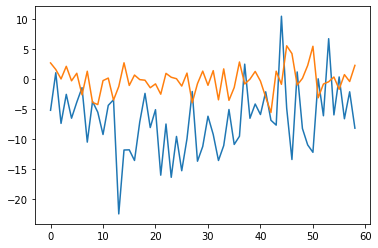









  4%|▍         | 201/5000 [01:00<28:18,  2.83it/s]







  4%|▍         | 202/5000 [01:01<27:09,  2.94it/s]







  4%|▍         | 203/5000 [01:01<26:20,  3.04it/s]







  4%|▍         | 204/5000 [01:01<25:43,  3.11it/s]







  4%|▍         | 205/5000 [01:02<25:09,  3.18it/s]







  4%|▍         | 206/5000 [01:02<24:53,  3.21it/s]







  4%|▍         | 207/5000 [01:02<24:40,  3.24it/s]







  4%|▍         | 208/5000 [01:02<24:23,  3.28it/s]







  4%|▍         | 209/5000 [01:03<24:05,  3.31it/s]







  4%|▍         | 210/5000 [01:03<24:18,  3.28it/s]







  4%|▍         | 211/5000 [01:03<24:19,  3.28it/s]







  4%|▍         | 212/5000 [01:04<24:03,  3.32it/s]







  4%|▍         | 213/5000 [01:04<24:04,  3.31it/s]







  4%|▍         | 214/5000 [01:04<24:10,  3.30it/s]







  4%|▍         | 215/5000 [01:05<24:15,  3.29it/s]







  4%|▍         | 216/5000 [01:05<24:12,  3.29it/s]







  4%|▍         | 217/5000 [01:05<24:09,  3.30it/s]







  4%|▍

MAE
9.7446069893194



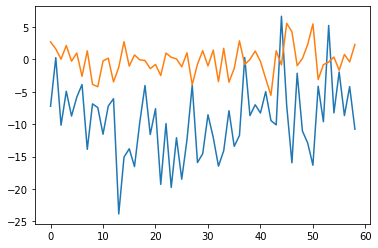









  5%|▌         | 251/5000 [01:16<28:14,  2.80it/s]







  5%|▌         | 252/5000 [01:16<26:56,  2.94it/s]







  5%|▌         | 253/5000 [01:16<25:59,  3.04it/s]







  5%|▌         | 254/5000 [01:17<25:18,  3.12it/s]







  5%|▌         | 255/5000 [01:17<25:12,  3.14it/s]







  5%|▌         | 256/5000 [01:17<25:15,  3.13it/s]







  5%|▌         | 257/5000 [01:18<25:10,  3.14it/s]







  5%|▌         | 258/5000 [01:18<25:01,  3.16it/s]







  5%|▌         | 259/5000 [01:18<24:31,  3.22it/s]







  5%|▌         | 260/5000 [01:18<24:28,  3.23it/s]







  5%|▌         | 261/5000 [01:19<24:02,  3.29it/s]







  5%|▌         | 262/5000 [01:19<23:50,  3.31it/s]







  5%|▌         | 263/5000 [01:19<23:47,  3.32it/s]







  5%|▌         | 264/5000 [01:20<23:48,  3.32it/s]







  5%|▌         | 265/5000 [01:20<23:48,  3.32it/s]







  5%|▌         | 266/5000 [01:20<23:49,  3.31it/s]







  5%|▌         | 267/5000 [01:21<23:43,  3.33it/s]







  5%|▌

KeyboardInterrupt: 

In [30]:
returns = run_GAN()

In [35]:
returns_generated = returns[0]
returns_true = returns[1]

NameError: name 'returns' is not defined

In [ ]:
plt.plot(returns_generated, label = 'generated')
plt.plot(returns_true, label = 'true')
plt.legend()

In [ ]:
#MAE
mean_absolute_error(returns_generated, returns_true)

In [ ]:
#calculate generated and real returns
returns_percent_generated = []
for i in range (1, len(returns_generated)):
    returns_percent_generated.append( (returns_generated[i] - returns_generated[i-1])/returns_generated[i-1])
returns_percent_true= []
for i in range (1, len(returns_true)):
    returns_percent_true.append( (returns_true[i] - returns_true[i-1])/returns_true[i-1])

In [ ]:
#trading strategy: buy if positive, nothing if negative
strategy_returns = []
for i in range (len(returns_percent_true)):
    if (returns_percent_generated[i] > 0):
        strategy_returns.append(returns_percent_true[i])
    else:
        strategy_returns.append(0)

In [ ]:
#eval strategy returns

#cumualtive reeturns real
cum_returns_real = 1
cum_ret_real = []
for i in range (len(returns_percent_true)):
    cum_returns_real  = cum_returns_real * (1 + returns_percent_true[i])
    cum_ret_real.append(cum_returns_real)
print (cum_returns_real)

#cumulative returns
cum_returns = 1
cum_ret = []
for i in range (len(strategy_returns)):
    cum_returns  = cum_returns * (1 + strategy_returns[i])
    cum_ret.append(cum_returns)
print (cum_returns)

#variance
variance = np.var(strategy_returns)
print (variance)

#sharpe real
std = np.std(returns_percent_true)
rfr = 0
sharpe = (np.average(returns_percent_true)- rfr)/std
print (sharpe)

#sharpe
std = np.std(strategy_returns)
rfr = 0
sharpe = (np.average(strategy_returns) - rfr)/std
print (sharpe)

#drawdown
previous_peaks = np.maximum.accumulate(cum_ret)
drawdown = (cum_ret-previous_peaks)/previous_peaks
max_drawdown = np.ndarray.min(drawdown)
print (max_drawdown)
plt.plot(drawdown)

#turnover
turnover = 0
for pred in strategy_returns:
    if (pred > 0):
        turnover += 1
turnover = turnover/len(strategy_returns)
print (turnover)

In [ ]:
plt.plot(cum_ret, label = 'strategy returns')
plt.plot(cum_ret_real, label = 'index returns')
plt.legend()

In [ ]:
sharpe = (np.average(strategy_returns) - 1 - rfr)/std
print (sharpe)



In [ ]:
np.var(strategy_returns)*100

In [ ]:
std